In [ ]:
import os
import glob
import random
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


In [29]:
import torch.serialization
torch.serialization.add_safe_globals([
    np.core.multiarray._reconstruct,
    np.ndarray,
])

In [3]:
base = os.path.join(os.getcwd(), 'five_fold_utils')


all_car_dict = np.load(os.path.join(base, 'all_car_dict.npz.npy'),
                       allow_pickle=True).item()

In [20]:
# 1,2,3번 딕셔너리 전부 로드
ind_odd_dicts = {}
for i in (1, 2, 3):
    fn = f'ind_odd_dict{i}.npz.npy'
    path = os.path.join(base, fn)
    ind_odd_dicts[i] = np.load(path, allow_pickle=True).item()

# 테스트로 내용 확인
for i, d in ind_odd_dicts.items():
    print(f"=== brand{i} ind/ood 리스트 ===")
    print("  정상 차량:", d['ind_sorted'])
    print("  비정상 차량:", d['ood_sorted'])

=== brand1 ind/ood 리스트 ===
  정상 차량: [129, 158, 152, 79, 95, 114, 34, 177, 99, 138, 163, 54, 45, 115, 66, 87, 47, 57, 31, 195, 36, 102, 72, 173, 94, 51, 92, 61, 153, 125, 103, 3, 50, 10, 7, 146, 166, 48, 75, 86, 15, 175, 64, 2, 110, 13, 23, 93, 116, 62, 8, 41, 22, 6, 24, 101, 46, 187, 198, 142, 131, 18, 160, 56, 29, 141, 148, 168, 71, 53, 104, 120, 154, 20, 17, 111, 133, 63, 35, 83, 5, 88, 159, 145, 176, 127, 77, 118, 52, 81, 121, 59, 38, 80, 109, 179, 28, 123, 44, 180, 149, 135, 164, 74, 40, 14, 65, 69, 42, 193, 12, 60, 73, 126, 161, 188, 32, 30, 170, 128, 167, 9, 155, 156, 43, 100, 33, 90, 139, 1, 112, 25, 4, 16, 189, 147, 124, 178, 55, 85, 122, 96, 162, 132, 89, 19, 27, 84, 39, 151, 67, 26, 172, 76, 37, 143, 58, 165, 97, 134, 82, 113, 137, 144, 70, 11, 117, 106]
  비정상 차량: [91, 192, 169, 130, 140, 171, 190, 186, 105, 49, 181, 157, 183, 185, 194, 98, 191, 136, 119, 196, 107, 68, 108, 78, 182, 150, 174, 21, 184, 197]
=== brand2 ind/ood 리스트 ===
  정상 차량: [214, 231, 233, 234, 218, 201, 211

In [5]:
def make_folds(ind_cars, ood_cars, car_dict, K=5):
    ind_folds = np.array_split(ind_cars, K)
    ood_folds = np.array_split(ood_cars, K)
    folds = []

    for k in range(K):
        test_cars  = set(ind_folds[k].tolist() + ood_folds[k].tolist())
        train_cars = set(ind_cars + ood_cars) - test_cars

        train_files = sum((car_dict[c] for c in train_cars), [])
        test_files  = sum((car_dict[c] for c in test_cars),  [])

        folds.append({
            'train_files': train_files,
            'test_files':  test_files
        })

    return folds

In [24]:
class BatteryDS(Dataset):
    def __init__(self, files):
        self.files = files
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        snippet, meta = torch.load(self.files[i], map_location='cpu',weights_only=False)
        # NumPy → Tensor 변환 시 float32로 캐스팅
        if not isinstance(snippet, torch.Tensor):
            snippet = torch.from_numpy(snippet).float()
        else:
            snippet = snippet.float()
        y = 0 if meta['label']=='00' else 1
        return snippet, torch.tensor(y)


In [7]:
def collate_fn(batch):
    seqs, labels = zip(*batch)
    # .shape[0] 은 NumPy array든 Tensor든 항상 동작
    lengths = torch.tensor([s.shape[0] for s in seqs], dtype=torch.long)
    padded  = pad_sequence(seqs, batch_first=True)
    return padded, lengths, torch.stack(labels)


In [26]:
import torch.nn.utils.rnn as rnn_utils
class LSTMCls(nn.Module):
    def __init__(self, in_feat, hidden=64, layers=2, num_cls=2):
        super().__init__()
        self.lstm = nn.LSTM(in_feat, hidden, layers, batch_first=True)
        self.fc   = nn.Linear(hidden, num_cls)

    def forward(self, x, lengths):
        packed = rnn_utils.pack_padded_sequence(
            x, lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        h_last = h_n[-1]               
        return self.fc(h_last)   


In [9]:
from sklearn.metrics import accuracy_score

In [10]:
from tqdm import tqdm

In [12]:
# 1) 브랜드1 train 폴더에서 .pkl 파일 리스트 가져오기
train_dir = os.path.join(os.getcwd(), 'dataset', 'battery_brand1', 'train')
pkl_files = glob.glob(os.path.join(train_dir, '*.pkl'))
if not pkl_files:
    raise RuntimeError(f"{train_dir}에 .pkl 파일이 없습니다.")

# 2) 첫 번째 파일 한 개 불러오기
sample_path = pkl_files[0]
print("읽어오는 파일:", sample_path)
snippet, meta = torch.load(sample_path, map_location='cpu',weights_only=False)

# 3) snippet 구조와 첫 타임스텝 값 출력
print("snippet shape:", snippet.shape)
print("features at t=0:", snippet[0])
print("메타데이터:", meta)

읽어오는 파일: /root/Deep_learning_Project/Battery_model/Nature23_battery_model/dataset/battery_brand1/train/60504.pkl
snippet shape: (128, 8)
features at t=0: [-2.959907   -0.653125   64.875       3.76803385  3.74459635 30.
 27.          0.        ]
메타데이터: OrderedDict([('label', '00'), ('car', 57), ('charge_segment', '736'), ('mileage', 1455.9160147656253)])


In [13]:
snippet[2]

array([ -2.41376848, -13.715625  ,  64.875     ,   3.77714844,
         3.75371094,  30.        ,  27.        ,  20.        ])

In [14]:
def get_brand_file_lists(brand_idx, base_dir, seed=42, train_ratio=0.8):
    """train/test 폴더 유무에 따라 파일 리스트를 반환"""
    brand_dir = os.path.join(base_dir, f"battery_brand{brand_idx}")
    train_dir = os.path.join(brand_dir, 'train')
    test_dir  = os.path.join(brand_dir, 'test')

    if os.path.isdir(train_dir) and os.path.isdir(test_dir):
        train_files = glob(os.path.join(train_dir, '*.pkl'))
        test_files  = glob(os.path.join(test_dir,  '*.pkl'))
    else:
        data_dir = os.path.join(brand_dir, 'data')
        all_files = glob(os.path.join(data_dir, '*.pkl'))
        random.seed(seed); random.shuffle(all_files)
        cut = int(len(all_files) * train_ratio)
        train_files, test_files = all_files[:cut], all_files[cut:]

    return train_files, test_files


In [15]:

def get_folds_for_brand(brand_idx, all_car_dict, ind_odd_dicts, K=5):
    """브랜드별로 valid 차량 dict만 뽑아서 make_folds 호출"""
    d = ind_odd_dicts[brand_idx]
    ind_cars = [c for c in d['ind_sorted'] if c in all_car_dict]
    ood_cars = [c for c in d['ood_sorted'] if c in all_car_dict]
    brand_car_dict = {c: all_car_dict[c] for c in (ind_cars + ood_cars)}
    return make_folds(ind_cars, ood_cars, brand_car_dict, K)


In [16]:

def get_dataloaders(train_files, test_files, batch_size=128, num_workers=4):
    """BatteryDS, collate_fn 은 이미 정의되어 있다고 가정"""
    tr_ds = BatteryDS(train_files)
    te_ds = BatteryDS(test_files)
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       collate_fn=collate_fn, pin_memory=True,
                       num_workers=num_workers)
    te_ld = DataLoader(te_ds, batch_size=batch_size, shuffle=False,
                       collate_fn=collate_fn, pin_memory=True,
                       num_workers=num_workers)
    return tr_ld, te_ld

In [17]:
device = torch.device('cuda:0')

In [18]:
from glob import glob
ase_dir = os.path.join(os.getcwd(), 'dataset')
all_stats   = {}
data_loaders = {}   # {(brand_idx, fold_idx): (tr_ld, te_ld)}

# 1) 먼저 all_car_dict, ind_odd_dicts 불러오고
# all_car_dict = np.load(...).item()
# ind_odd_dicts = {...}

# 2) 각 브랜드, 각 폴드마다 train/test DataLoader 준비
for b in (1,2,3):
    # 파일 리스트(brand1·2는 train/test, brand3는 data split)
    train_files, test_files = get_brand_file_lists(b, base)
    # 폴드별 파일 분할
    folds = get_folds_for_brand(b, all_car_dict, ind_odd_dicts, K=5)
    for k, fold in enumerate(folds):
        tr_ld, te_ld = get_dataloaders(fold['train_files'], fold['test_files'])
        data_loaders[(b, k+1)] = (tr_ld, te_ld)


In [ ]:
def train_fold(brand_idx, fold_idx, device, data_loaders, epochs=5):
    tr_ld, te_ld = data_loaders[(brand_idx, fold_idx)]
    model = LSTMCls(in_feat=8).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for x, lengths, y in tr_ld:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x, lengths)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(tr_ld)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, lengths, y in te_ld:
                x, lengths, y = x.to(device), lengths.to(device), y.to(device)
                logits = model(x, lengths)
                pred = logits.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        val_accuracies.append(val_acc)

        print(f"[Brand{brand_idx} Fold{fold_idx}] Epoch {epoch}: Loss={avg_loss:.4f}, Val Acc={val_acc:.4f}")

    fold_stats = {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'final_val_acc': val_accuracies[-1],
        'model_state_dict': model.state_dict()
    }

    return model, fold_stats


In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
all_stats = {}

for b in (1, 2, 3):
    print(f"\n=== 브랜드 {b} 학습 시작 ===")
    all_stats[f"brand{b}"] = {}
    for k in range(1, 6):
        print(f"\n--- Fold {k}/5 ---")
        model, stats = train_fold(b, k, device, data_loaders)
        all_stats[f"brand{b}"][f"fold_{k}"] = stats



=== 브랜드 1 학습 시작 ===

--- Fold 1/5 ---


UnpicklingError: Caught UnpicklingError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    else:
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2974047/1635444275.py", line 7, in __getitem__
    snippet, meta = torch.load(self.files[i], map_location='cpu')
  File "/opt/conda/lib/python3.10/site-packages/torch/serialization.py", line 1524, in load
    (ndim,) = struct.unpack("<i", f.read(4))
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.dtype was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.dtype])` or the `torch.serialization.safe_globals([numpy.dtype])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.


In [ ]:
best_fold_info = None
best_val_acc = -1

for k in range(1, 6):
    stats = all_stats[f"brand{b}"][f"fold_{k}"]
    if stats['final_val_acc'] > best_val_acc:
        best_val_acc = stats['final_val_acc']
        best_fold_info = {
            'fold_idx': k,
            'model_state_dict': stats.get('model_state_dict'),  # 필요 시 저장
            'hyperparams': {
                'hidden': 64,  # 예시, 실사용시 변수화
                'layers': 2,
                'lr': 1e-3,
                'epochs': 5
            }
        }

In [115]:
if __name__ == '__main__':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    all_stats = {}
    for b in (1, 2, 3):
        stats = run_brand(b, device)
        all_stats[f"brand{b}"] = stats


=== Brand1 Training ===

-- Fold 1/5 --


Brand1-Fold1 Epochs:  20%|██        | 1/5 [02:04<08:19, 124.80s/it]

 Epoch01 loss=0.1436 acc=0.9561


Brand1-Fold1 Epochs:  40%|████      | 2/5 [04:06<06:09, 123.03s/it]

 Epoch02 loss=0.1396 acc=0.9561


Brand1-Fold1 Epochs:  60%|██████    | 3/5 [06:04<04:01, 120.68s/it]

 Epoch03 loss=0.1394 acc=0.9561


Brand1-Fold1 Epochs:  80%|████████  | 4/5 [08:03<01:59, 119.92s/it]

 Epoch04 loss=0.1390 acc=0.9561


 Epoch05 loss=0.1385 acc=0.9561
 → Fold 1 best epoch=1, best_acc=0.9561
    saved model: models/brand1/brand1_fold1_best.pth

-- Fold 2/5 --


Brand1-Fold2 Epochs:  20%|██        | 1/5 [01:59<07:58, 119.58s/it]

 Epoch01 loss=0.1558 acc=0.9711


Brand1-Fold2 Epochs:  40%|████      | 2/5 [03:59<05:58, 119.61s/it]

 Epoch02 loss=0.1533 acc=0.9711


Brand1-Fold2 Epochs:  60%|██████    | 3/5 [05:56<03:57, 118.63s/it]

 Epoch03 loss=0.1530 acc=0.9711


Brand1-Fold2 Epochs:  80%|████████  | 4/5 [08:03<02:01, 121.97s/it]

 Epoch04 loss=0.1527 acc=0.9711


 Epoch05 loss=0.1521 acc=0.9711
 → Fold 2 best epoch=1, best_acc=0.9711
    saved model: models/brand1/brand1_fold2_best.pth

-- Fold 3/5 --


Brand1-Fold3 Epochs:  20%|██        | 1/5 [01:56<07:44, 116.19s/it]

 Epoch01 loss=0.1518 acc=0.9607


Brand1-Fold3 Epochs:  40%|████      | 2/5 [03:53<05:50, 116.91s/it]

 Epoch02 loss=0.1502 acc=0.9607


Brand1-Fold3 Epochs:  60%|██████    | 3/5 [05:50<03:53, 116.77s/it]

 Epoch03 loss=0.1498 acc=0.9607


Brand1-Fold3 Epochs:  80%|████████  | 4/5 [07:45<01:56, 116.38s/it]

 Epoch04 loss=0.1494 acc=0.9607


 Epoch05 loss=0.1493 acc=0.9607
 → Fold 3 best epoch=1, best_acc=0.9607
    saved model: models/brand1/brand1_fold3_best.pth

-- Fold 4/5 --


Brand1-Fold4 Epochs:  20%|██        | 1/5 [01:58<07:53, 118.39s/it]

 Epoch01 loss=0.1425 acc=0.9532


Brand1-Fold4 Epochs:  40%|████      | 2/5 [03:53<05:49, 116.64s/it]

 Epoch02 loss=0.1392 acc=0.9532


Brand1-Fold4 Epochs:  60%|██████    | 3/5 [05:45<03:48, 114.38s/it]

 Epoch03 loss=0.1386 acc=0.9532


Brand1-Fold4 Epochs:  80%|████████  | 4/5 [07:38<01:53, 113.83s/it]

 Epoch04 loss=0.1380 acc=0.9532


 Epoch05 loss=0.1376 acc=0.9532
 → Fold 4 best epoch=1, best_acc=0.9532
    saved model: models/brand1/brand1_fold4_best.pth

-- Fold 5/5 --


Brand1-Fold5 Epochs:  20%|██        | 1/5 [01:53<07:35, 113.96s/it]

 Epoch01 loss=0.1707 acc=0.9863


Brand1-Fold5 Epochs:  40%|████      | 2/5 [03:48<05:42, 114.22s/it]

 Epoch02 loss=0.1677 acc=0.9863


Brand1-Fold5 Epochs:  60%|██████    | 3/5 [05:41<03:47, 113.77s/it]

 Epoch03 loss=0.1670 acc=0.9863


Brand1-Fold5 Epochs:  80%|████████  | 4/5 [07:36<01:54, 114.13s/it]

 Epoch04 loss=0.1673 acc=0.9863


 Epoch05 loss=0.1668 acc=0.9863
 → Fold 5 best epoch=1, best_acc=0.9863
    saved model: models/brand1/brand1_fold5_best.pth

=== Brand2 Training ===

-- Fold 1/5 --


Brand2-Fold1 Epochs:  20%|██        | 1/5 [00:42<02:49, 42.49s/it]

 Epoch01 loss=0.5642 acc=0.6416


Brand2-Fold1 Epochs:  40%|████      | 2/5 [01:24<02:05, 42.00s/it]

 Epoch02 loss=0.5314 acc=0.5915


Brand2-Fold1 Epochs:  60%|██████    | 3/5 [02:05<01:23, 41.88s/it]

 Epoch03 loss=0.5226 acc=0.6905


Brand2-Fold1 Epochs:  80%|████████  | 4/5 [02:48<00:42, 42.09s/it]

 Epoch04 loss=0.5157 acc=0.5802


 Epoch05 loss=0.5035 acc=0.6385
 → Fold 1 best epoch=3, best_acc=0.6905
    saved model: models/brand2/brand2_fold1_best.pth

-- Fold 2/5 --


Brand2-Fold2 Epochs:  20%|██        | 1/5 [00:44<02:56, 44.19s/it]

 Epoch01 loss=0.5681 acc=0.6898


Brand2-Fold2 Epochs:  40%|████      | 2/5 [01:29<02:13, 44.64s/it]

 Epoch02 loss=0.5485 acc=0.6044


Brand2-Fold2 Epochs:  60%|██████    | 3/5 [02:15<01:30, 45.29s/it]

 Epoch03 loss=0.5414 acc=0.6618


Brand2-Fold2 Epochs:  80%|████████  | 4/5 [03:00<00:45, 45.36s/it]

 Epoch04 loss=0.5366 acc=0.6724


 Epoch05 loss=0.5317 acc=0.6202
 → Fold 2 best epoch=1, best_acc=0.6898
    saved model: models/brand2/brand2_fold2_best.pth

-- Fold 3/5 --


Brand2-Fold3 Epochs:  20%|██        | 1/5 [00:44<02:58, 44.70s/it]

 Epoch01 loss=0.5575 acc=0.3780


Brand2-Fold3 Epochs:  40%|████      | 2/5 [01:30<02:15, 45.21s/it]

 Epoch02 loss=0.5409 acc=0.5542


Brand2-Fold3 Epochs:  60%|██████    | 3/5 [02:14<01:29, 44.80s/it]

 Epoch03 loss=0.5358 acc=0.4839


Brand2-Fold3 Epochs:  80%|████████  | 4/5 [02:58<00:44, 44.60s/it]

 Epoch04 loss=0.5334 acc=0.4794


 Epoch05 loss=0.5300 acc=0.4739
 → Fold 3 best epoch=2, best_acc=0.5542
    saved model: models/brand2/brand2_fold3_best.pth

-- Fold 4/5 --


Brand2-Fold4 Epochs:  20%|██        | 1/5 [00:44<02:57, 44.31s/it]

 Epoch01 loss=0.6001 acc=0.8974


Brand2-Fold4 Epochs:  40%|████      | 2/5 [01:29<02:15, 45.02s/it]

 Epoch02 loss=0.5719 acc=0.8130


Brand2-Fold4 Epochs:  60%|██████    | 3/5 [02:13<01:29, 44.54s/it]

 Epoch03 loss=0.5615 acc=0.8668


Brand2-Fold4 Epochs:  80%|████████  | 4/5 [02:58<00:44, 44.72s/it]

 Epoch04 loss=0.5533 acc=0.8385


 Epoch05 loss=0.5434 acc=0.6929
 → Fold 4 best epoch=1, best_acc=0.8974
    saved model: models/brand2/brand2_fold4_best.pth

-- Fold 5/5 --


Brand2-Fold5 Epochs:  20%|██        | 1/5 [00:44<02:56, 44.08s/it]

 Epoch01 loss=0.5423 acc=0.5279


Brand2-Fold5 Epochs:  40%|████      | 2/5 [01:29<02:13, 44.65s/it]

 Epoch02 loss=0.5157 acc=0.5438


Brand2-Fold5 Epochs:  60%|██████    | 3/5 [02:16<01:31, 45.85s/it]

 Epoch03 loss=0.5107 acc=0.4769


Brand2-Fold5 Epochs:  80%|████████  | 4/5 [03:02<00:45, 45.96s/it]

 Epoch04 loss=0.5047 acc=0.5358


 Epoch05 loss=0.5031 acc=0.5139
 → Fold 5 best epoch=2, best_acc=0.5438
    saved model: models/brand2/brand2_fold5_best.pth

=== Brand3 Training ===

-- Fold 1/5 --


Brand3-Fold1 Epochs:  20%|██        | 1/5 [00:06<00:27,  6.76s/it]

 Epoch01 loss=0.2064 acc=0.9218


Brand3-Fold1 Epochs:  40%|████      | 2/5 [00:13<00:20,  6.91s/it]

 Epoch02 loss=0.1658 acc=0.9341


Brand3-Fold1 Epochs:  60%|██████    | 3/5 [00:20<00:13,  6.69s/it]

 Epoch03 loss=0.1646 acc=0.9341


Brand3-Fold1 Epochs:  80%|████████  | 4/5 [00:27<00:06,  6.89s/it]

 Epoch04 loss=0.1540 acc=0.9342


 Epoch05 loss=0.1525 acc=0.9308
 → Fold 1 best epoch=4, best_acc=0.9342
    saved model: models/brand3/brand3_fold1_best.pth

-- Fold 2/5 --


Brand3-Fold2 Epochs:  20%|██        | 1/5 [00:06<00:27,  6.98s/it]

 Epoch01 loss=0.2268 acc=0.9514


Brand3-Fold2 Epochs:  40%|████      | 2/5 [00:13<00:20,  6.89s/it]

 Epoch02 loss=0.1783 acc=0.9516


Brand3-Fold2 Epochs:  60%|██████    | 3/5 [00:20<00:13,  6.64s/it]

 Epoch03 loss=0.1779 acc=0.9516


Brand3-Fold2 Epochs:  80%|████████  | 4/5 [00:26<00:06,  6.66s/it]

 Epoch04 loss=0.1761 acc=0.9518


 Epoch05 loss=0.1724 acc=0.9516
 → Fold 2 best epoch=4, best_acc=0.9518
    saved model: models/brand3/brand3_fold2_best.pth

-- Fold 3/5 --


Brand3-Fold3 Epochs:  20%|██        | 1/5 [00:06<00:25,  6.42s/it]

 Epoch01 loss=0.2224 acc=0.9363


Brand3-Fold3 Epochs:  40%|████      | 2/5 [00:12<00:19,  6.46s/it]

 Epoch02 loss=0.1814 acc=0.9478


Brand3-Fold3 Epochs:  60%|██████    | 3/5 [00:19<00:13,  6.70s/it]

 Epoch03 loss=0.1736 acc=0.9442


Brand3-Fold3 Epochs:  80%|████████  | 4/5 [00:26<00:06,  6.65s/it]

 Epoch04 loss=0.1706 acc=0.9518


 Epoch05 loss=0.1642 acc=0.9522
 → Fold 3 best epoch=5, best_acc=0.9522
    saved model: models/brand3/brand3_fold3_best.pth

-- Fold 4/5 --


Brand3-Fold4 Epochs:  20%|██        | 1/5 [00:06<00:25,  6.45s/it]

 Epoch01 loss=0.2141 acc=0.8993


Brand3-Fold4 Epochs:  40%|████      | 2/5 [00:13<00:21,  7.04s/it]

 Epoch02 loss=0.1639 acc=0.8993


Brand3-Fold4 Epochs:  60%|██████    | 3/5 [00:20<00:13,  6.91s/it]

 Epoch03 loss=0.1489 acc=0.9052


Brand3-Fold4 Epochs:  80%|████████  | 4/5 [00:27<00:06,  6.75s/it]

 Epoch04 loss=0.1456 acc=0.9144


 Epoch05 loss=0.1402 acc=0.9120
 → Fold 4 best epoch=4, best_acc=0.9144
    saved model: models/brand3/brand3_fold4_best.pth

-- Fold 5/5 --


Brand3-Fold5 Epochs:  20%|██        | 1/5 [00:06<00:26,  6.68s/it]

 Epoch01 loss=0.2464 acc=0.9865


Brand3-Fold5 Epochs:  40%|████      | 2/5 [00:13<00:19,  6.56s/it]

 Epoch02 loss=0.2130 acc=0.9865


Brand3-Fold5 Epochs:  60%|██████    | 3/5 [00:20<00:13,  6.80s/it]

 Epoch03 loss=0.2184 acc=0.9816


Brand3-Fold5 Epochs:  80%|████████  | 4/5 [00:26<00:06,  6.76s/it]

 Epoch04 loss=0.2054 acc=0.9845


 Epoch05 loss=0.2049 acc=0.9865
 → Fold 5 best epoch=1, best_acc=0.9865
    saved model: models/brand3/brand3_fold5_best.pth


In [116]:
all_stats

{'brand1': {'fold_1': {'epoch_loss': [0.1435640859252339,
    0.1396165911350655,
    0.13936080525748237,
    0.1389702183693899,
    0.13848064880183467],
   'epoch_acc': [0.9561092468952157,
    0.9561092468952157,
    0.9561092468952157,
    0.9561092468952157,
    0.9561092468952157],
   'best_acc': 0.9561092468952157,
   'best_epoch': 1,
   'best_model_path': 'models/brand1/brand1_fold1_best.pth'},
  'fold_2': {'epoch_loss': [0.155779407104993,
    0.15332159619053592,
    0.15295111334393968,
    0.15268694752173,
    0.15212910111989877],
   'epoch_acc': [0.9711056265917505,
    0.9711056265917505,
    0.9711056265917505,
    0.9711056265917505,
    0.9711056265917505],
   'best_acc': 0.9711056265917505,
   'best_epoch': 1,
   'best_model_path': 'models/brand1/brand1_fold2_best.pth'},
  'fold_3': {'epoch_loss': [0.15179033963110822,
    0.1501947934430831,
    0.14981919023824244,
    0.14942494875077708,
    0.14927500394357457],
   'epoch_acc': [0.9607194108959117,
    0.9607

/tmp/ipykernel_2974047/3954603383.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


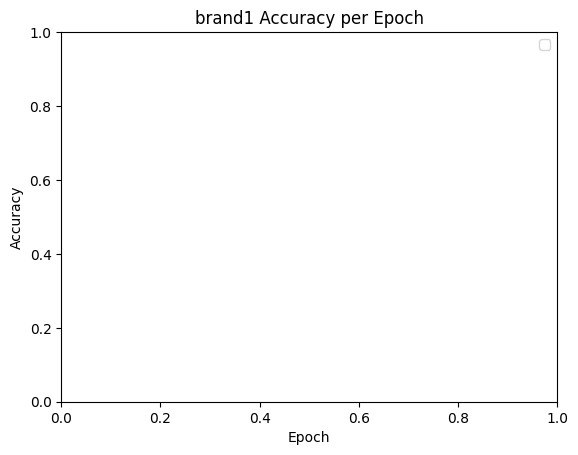

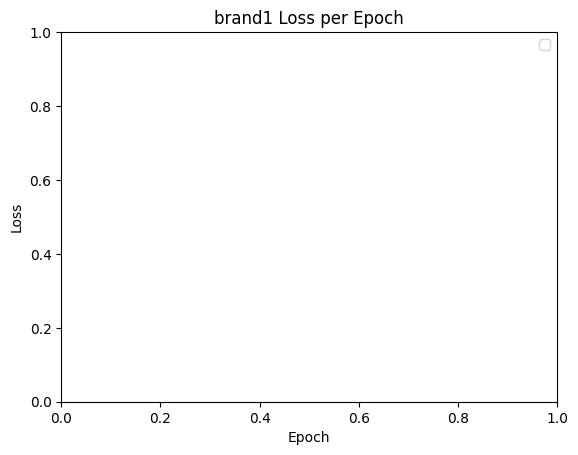

In [35]:
import matplotlib.pyplot as plt
for metric in ("epoch_acc", "epoch_loss"):
    for brand, stats in all_stats.items():
        plt.figure()
        for fold_key, fold_stats in stats.items():
            values = fold_stats[metric]
            epochs = range(1, len(values) + 1)
            plt.plot(epochs, values, label=fold_key)
        title = "Accuracy" if metric == "epoch_acc" else "Loss"
        plt.title(f"{brand} {title} per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(title)
        plt.legend()
        plt.show()

In [38]:
best_folds = {
    1: 5,  # Brand1 Fold5 acc=0.9863
    2: 4,  # Brand2 Fold4 acc=0.8974
    3: 3   # Brand3 Fold3 acc=0.9522
}


In [44]:
def retrain_from_model_path(brand_idx, best_fold_idx, device, all_car_dict, ind_odd_dicts, model_dir='models', epochs=5):
    print(f"\n==> Retraining Brand{brand_idx} on full data from Fold{best_fold_idx} best model")

    d = ind_odd_dicts[brand_idx]
    ind_cars = [c for c in d['ind_sorted'] if c in all_car_dict]
    ood_cars = [c for c in d['ood_sorted'] if c in all_car_dict]
    all_cars = ind_cars + ood_cars

    full_train_files = sum([all_car_dict[c] for c in all_cars], [])
    tr_ld, _ = get_dataloaders(full_train_files, full_train_files, num_workers=0)

    # 모델 불러오기
    best_model_path = f"{model_dir}/brand{brand_idx}/brand{brand_idx}_fold{best_fold_idx}_best.pth"
    model = LSTMCls(in_feat=8).to(device)
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(1, epochs + 1), desc=f"brand {brand_idx} training ", leave = False):
        model.train()
        total_loss = 0
        correct = total = 0
        for x, lengths, y in tr_ld:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x, lengths)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        print(f"[Brand{brand_idx}-FULL] Epoch{epoch:02d}: loss={total_loss/len(tr_ld):.4f} acc={correct/total:.4f}")

    save_path = f"{model_dir}/brand{brand_idx}/brand{brand_idx}_final_full_model.pth"
    torch.save(model.state_dict(), save_path)
    print(f"=> Saved full retrained model to {save_path}")


In [45]:
for b in (1, 2, 3):
    retrain_from_model_path(
        brand_idx=b,
        best_fold_idx=best_folds[b],
        device=device,
        all_car_dict=all_car_dict,
        ind_odd_dicts=ind_odd_dicts,
        model_dir='models',
        epochs=5
    )


==> Retraining Brand1 on full data from Fold5 best model


brand 1 training :  20%|██        | 1/5 [02:49<11:19, 169.83s/it]

[Brand1-FULL] Epoch01: loss=0.1518 acc=0.9643


brand 1 training :  40%|████      | 2/5 [05:11<07:39, 153.29s/it]

[Brand1-FULL] Epoch02: loss=0.1509 acc=0.9643


brand 1 training :  60%|██████    | 3/5 [07:29<04:52, 146.27s/it]

[Brand1-FULL] Epoch03: loss=0.1506 acc=0.9643


brand 1 training :  80%|████████  | 4/5 [09:47<02:22, 142.97s/it]

[Brand1-FULL] Epoch04: loss=0.1503 acc=0.9643


[Brand1-FULL] Epoch05: loss=0.1503 acc=0.9643
=> Saved full retrained model to models/brand1/brand1_final_full_model.pth

==> Retraining Brand2 on full data from Fold4 best model


brand 2 training :  20%|██        | 1/5 [01:58<07:54, 118.52s/it]

[Brand2-FULL] Epoch01: loss=0.5473 acc=0.7223


brand 2 training :  40%|████      | 2/5 [03:47<05:38, 112.83s/it]

[Brand2-FULL] Epoch02: loss=0.5316 acc=0.7322


brand 2 training :  60%|██████    | 3/5 [05:35<03:41, 110.74s/it]

[Brand2-FULL] Epoch03: loss=0.5198 acc=0.7391


brand 2 training :  80%|████████  | 4/5 [07:25<01:50, 110.21s/it]

[Brand2-FULL] Epoch04: loss=0.5108 acc=0.7443


[Brand2-FULL] Epoch05: loss=0.5028 acc=0.7496
=> Saved full retrained model to models/brand2/brand2_final_full_model.pth

==> Retraining Brand3 on full data from Fold3 best model


brand 3 training :  20%|██        | 1/5 [00:08<00:33,  8.28s/it]

[Brand3-FULL] Epoch01: loss=0.1538 acc=0.9484


brand 3 training :  40%|████      | 2/5 [00:16<00:25,  8.53s/it]

[Brand3-FULL] Epoch02: loss=0.1693 acc=0.9472


brand 3 training :  60%|██████    | 3/5 [00:25<00:17,  8.69s/it]

[Brand3-FULL] Epoch03: loss=0.1804 acc=0.9487


brand 3 training :  80%|████████  | 4/5 [00:33<00:08,  8.41s/it]

[Brand3-FULL] Epoch04: loss=0.1673 acc=0.9482


[Brand3-FULL] Epoch05: loss=0.1627 acc=0.9485
=> Saved full retrained model to models/brand3/brand3_final_full_model.pth


In [46]:
retrain_from_model_path(
        brand_idx=2,
        best_fold_idx=best_folds[2],
        device=device,
        all_car_dict=all_car_dict,
        ind_odd_dicts=ind_odd_dicts,
        model_dir='models',
        epochs=20
    )


==> Retraining Brand2 on full data from Fold4 best model


brand 2 training :   5%|▌         | 1/20 [01:50<34:52, 110.12s/it]

[Brand2-FULL] Epoch01: loss=0.5481 acc=0.7227


brand 2 training :  10%|█         | 2/20 [03:39<32:57, 109.88s/it]

[Brand2-FULL] Epoch02: loss=0.5333 acc=0.7307


brand 2 training :  15%|█▌        | 3/20 [05:32<31:30, 111.21s/it]

[Brand2-FULL] Epoch03: loss=0.5197 acc=0.7398


brand 2 training :  20%|██        | 4/20 [07:22<29:33, 110.83s/it]

[Brand2-FULL] Epoch04: loss=0.5130 acc=0.7435


brand 2 training :  25%|██▌       | 5/20 [09:13<27:40, 110.68s/it]

[Brand2-FULL] Epoch05: loss=0.5028 acc=0.7488


brand 2 training :  30%|███       | 6/20 [11:01<25:36, 109.78s/it]

[Brand2-FULL] Epoch06: loss=0.4949 acc=0.7531


brand 2 training :  35%|███▌      | 7/20 [12:48<23:36, 108.93s/it]

[Brand2-FULL] Epoch07: loss=0.4790 acc=0.7629


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2974047/120446467.py", line 1, in <module>
    retrain_from_model_path(
  File "/tmp/ipykernel_2974047/1073536034.py", line 24, in retrain_from_model_path
    for x, lengths, y in tr_ld:
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 733, in __next__
    class _SingleProcessDataLoaderIter(_BaseDataLoaderIter):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 789, in _next_data
    #
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibl

In [ ]:
class LSTMforBrand2(nn.Module):
    def __init__(self, in_feat, hidden=128, layers=3, num_cls=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_feat,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0  # PyTorch 제한
        )
        self.fc = nn.Linear(hidden, num_cls)
    
    def forward(self, x, lengths):
        packed = rnn_utils.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        h_last = h_n[-1]
        return self.fc(h_last)

In [63]:
def retrain_brand2_with_upgraded_model(device, all_car_dict, ind_odd_dicts,
                                       model_dir='models', epochs=20, lr=1e-4):
    brand_idx = 2
    print(f"\n==> Retraining Brand{brand_idx} with upgraded model from scratch")
    save_dir = os.path.join(model_dir, 'brand2')
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, 'brand2_final_full_model_v2.pth')

    
    # 1. 전체 차량 수집
    d = ind_odd_dicts[brand_idx]
    ind_cars = [c for c in d['ind_sorted'] if c in all_car_dict]
    ood_cars = [c for c in d['ood_sorted'] if c in all_car_dict]
    all_cars = ind_cars + ood_cars

    full_train_files = sum([all_car_dict[c] for c in all_cars], [])
    tr_ld, _ = get_dataloaders(full_train_files, full_train_files, num_workers=0)

    # 2. 모델 정의 (새 구조)
    model = LSTMforBrand2(in_feat=8, hidden=128, layers=3, dropout=0.3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss()
    
    if os.path.exists(save_path):
        print(f"==> Loading existing model from {save_path}")
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint)    
    
    # 3. 학습 루프
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        total_loss = 0
        correct = total = 0
        for x, lengths, y in tr_ld:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x, lengths)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        acc = correct / total
        avg_loss = total_loss / len(tr_ld)
        print(f"[Brand2-FULL v2] Epoch{epoch:02d}: loss={avg_loss:.4f} acc={acc:.4f}")
        scheduler.step(avg_loss)

    # 4. 저장
    torch.save(model.state_dict(), save_path)
    print(f"=> Saved upgraded full model to {save_path}")



In [49]:
retrain_brand2_with_upgraded_model(
    device=device,
    all_car_dict=all_car_dict,
    ind_odd_dicts=ind_odd_dicts,
    model_dir='models',
    epochs=20,
    lr=1e-4
)


==> Retraining Brand2 with upgraded model from scratch


  5%|▌         | 1/20 [01:55<36:30, 115.27s/it]

[Brand2-FULL v2] Epoch01: loss=0.5740 acc=0.7033


 10%|█         | 2/20 [03:51<34:43, 115.78s/it]

[Brand2-FULL v2] Epoch02: loss=0.5462 acc=0.7227


 15%|█▌        | 3/20 [05:47<32:50, 115.92s/it]

[Brand2-FULL v2] Epoch03: loss=0.5350 acc=0.7290


 20%|██        | 4/20 [07:41<30:40, 115.02s/it]

[Brand2-FULL v2] Epoch04: loss=0.5250 acc=0.7355


 25%|██▌       | 5/20 [09:35<28:39, 114.61s/it]

[Brand2-FULL v2] Epoch05: loss=0.5165 acc=0.7404


 30%|███       | 6/20 [11:32<26:58, 115.60s/it]

[Brand2-FULL v2] Epoch06: loss=0.5067 acc=0.7462


 35%|███▌      | 7/20 [13:28<25:06, 115.86s/it]

[Brand2-FULL v2] Epoch07: loss=0.4992 acc=0.7509


 40%|████      | 8/20 [15:29<23:26, 117.24s/it]

[Brand2-FULL v2] Epoch08: loss=0.4918 acc=0.7553


 45%|████▌     | 9/20 [17:24<21:24, 116.80s/it]

[Brand2-FULL v2] Epoch09: loss=0.4861 acc=0.7583


 50%|█████     | 10/20 [19:20<19:23, 116.32s/it]

[Brand2-FULL v2] Epoch10: loss=0.4804 acc=0.7616


 55%|█████▌    | 11/20 [21:15<17:23, 115.95s/it]

[Brand2-FULL v2] Epoch11: loss=0.4751 acc=0.7647


 60%|██████    | 12/20 [23:10<15:26, 115.80s/it]

[Brand2-FULL v2] Epoch12: loss=0.4688 acc=0.7680


 65%|██████▌   | 13/20 [25:05<13:27, 115.35s/it]

[Brand2-FULL v2] Epoch13: loss=0.4588 acc=0.7739


 70%|███████   | 14/20 [26:58<11:29, 114.84s/it]

[Brand2-FULL v2] Epoch14: loss=0.4446 acc=0.7811


 75%|███████▌  | 15/20 [28:56<09:38, 115.61s/it]

[Brand2-FULL v2] Epoch15: loss=0.4281 acc=0.7890


 80%|████████  | 16/20 [30:50<07:41, 115.38s/it]

[Brand2-FULL v2] Epoch16: loss=0.4175 acc=0.7939


 85%|████████▌ | 17/20 [32:46<05:45, 115.30s/it]

[Brand2-FULL v2] Epoch17: loss=0.4187 acc=0.7938


 90%|█████████ | 18/20 [34:40<03:50, 115.07s/it]

[Brand2-FULL v2] Epoch18: loss=0.4120 acc=0.7987


 95%|█████████▌| 19/20 [36:38<01:55, 115.87s/it]

[Brand2-FULL v2] Epoch19: loss=0.3983 acc=0.8054


100%|██████████| 20/20 [38:37<00:00, 115.86s/it]

[Brand2-FULL v2] Epoch20: loss=0.3919 acc=0.8093
=> Saved upgraded full model to models/brand2/brand2_final_full_model_v2.pth


In [64]:
retrain_brand2_with_upgraded_model(
    device=device,
    all_car_dict=all_car_dict,
    ind_odd_dicts=ind_odd_dicts,
    model_dir='models',
    epochs=20,
    lr=1e-4
)


==> Retraining Brand2 with upgraded model from scratch
==> Loading existing model from models/brand2/brand2_final_full_model_v2.pth


  5%|▌         | 1/20 [01:57<37:17, 117.75s/it]

[Brand2-FULL v2] Epoch01: loss=0.3808 acc=0.8160


 10%|█         | 2/20 [03:54<35:06, 117.00s/it]

[Brand2-FULL v2] Epoch02: loss=0.3696 acc=0.8233


 15%|█▌        | 3/20 [05:48<32:49, 115.85s/it]

[Brand2-FULL v2] Epoch03: loss=0.3615 acc=0.8274


 20%|██        | 4/20 [07:42<30:40, 115.04s/it]

[Brand2-FULL v2] Epoch04: loss=0.3625 acc=0.8264


 25%|██▌       | 5/20 [09:35<28:34, 114.30s/it]

[Brand2-FULL v2] Epoch05: loss=0.3540 acc=0.8325


 30%|███       | 6/20 [11:28<26:36, 114.01s/it]

[Brand2-FULL v2] Epoch06: loss=0.3418 acc=0.8400


 35%|███▌      | 7/20 [13:22<24:39, 113.83s/it]

[Brand2-FULL v2] Epoch07: loss=0.3300 acc=0.8481


 40%|████      | 8/20 [15:14<22:41, 113.44s/it]

[Brand2-FULL v2] Epoch08: loss=0.3435 acc=0.8378


 45%|████▌     | 9/20 [17:10<20:55, 114.12s/it]

[Brand2-FULL v2] Epoch09: loss=0.3319 acc=0.8454


 50%|█████     | 10/20 [19:06<19:06, 114.63s/it]

[Brand2-FULL v2] Epoch10: loss=0.3242 acc=0.8507


 55%|█████▌    | 11/20 [21:01<17:12, 114.77s/it]

[Brand2-FULL v2] Epoch11: loss=0.3133 acc=0.8573


 60%|██████    | 12/20 [22:54<15:14, 114.36s/it]

[Brand2-FULL v2] Epoch12: loss=0.3128 acc=0.8574


 65%|██████▌   | 13/20 [24:47<13:17, 113.86s/it]

[Brand2-FULL v2] Epoch13: loss=0.3040 acc=0.8626


 70%|███████   | 14/20 [26:43<11:26, 114.37s/it]

[Brand2-FULL v2] Epoch14: loss=0.3026 acc=0.8631


 75%|███████▌  | 15/20 [28:38<09:32, 114.59s/it]

[Brand2-FULL v2] Epoch15: loss=0.3057 acc=0.8606


 80%|████████  | 16/20 [30:32<07:38, 114.56s/it]

[Brand2-FULL v2] Epoch16: loss=0.2948 acc=0.8670


 85%|████████▌ | 17/20 [32:26<05:43, 114.47s/it]

[Brand2-FULL v2] Epoch17: loss=0.2964 acc=0.8661


 90%|█████████ | 18/20 [34:21<03:49, 114.56s/it]

[Brand2-FULL v2] Epoch18: loss=0.2963 acc=0.8656


 95%|█████████▌| 19/20 [36:15<01:54, 114.19s/it]

[Brand2-FULL v2] Epoch19: loss=0.2937 acc=0.8673


100%|██████████| 20/20 [38:09<00:00, 114.48s/it]

[Brand2-FULL v2] Epoch20: loss=0.2852 acc=0.8718
=> Saved upgraded full model to models/brand2/brand2_final_full_model_v2.pth


In [65]:
retrain_brand2_with_upgraded_model(
    device=device,
    all_car_dict=all_car_dict,
    ind_odd_dicts=ind_odd_dicts,
    model_dir='models',
    epochs=20,
    lr=1e-4
)


==> Retraining Brand2 with upgraded model from scratch
==> Loading existing model from models/brand2/brand2_final_full_model_v2.pth


  5%|▌         | 1/20 [01:57<37:04, 117.08s/it]

[Brand2-FULL v2] Epoch01: loss=0.2949 acc=0.8664


 10%|█         | 2/20 [03:53<34:59, 116.66s/it]

[Brand2-FULL v2] Epoch02: loss=0.2866 acc=0.8710


 15%|█▌        | 3/20 [05:52<33:24, 117.89s/it]

[Brand2-FULL v2] Epoch03: loss=0.2866 acc=0.8704


 20%|██        | 4/20 [07:45<30:53, 115.82s/it]

[Brand2-FULL v2] Epoch04: loss=0.2855 acc=0.8709


 25%|██▌       | 5/20 [09:37<28:38, 114.58s/it]

[Brand2-FULL v2] Epoch05: loss=0.2834 acc=0.8722


 30%|███       | 6/20 [11:30<26:37, 114.09s/it]

[Brand2-FULL v2] Epoch06: loss=0.2788 acc=0.8746


 35%|███▌      | 7/20 [13:23<24:36, 113.54s/it]

[Brand2-FULL v2] Epoch07: loss=0.2780 acc=0.8755


 40%|████      | 8/20 [15:16<22:40, 113.39s/it]

[Brand2-FULL v2] Epoch08: loss=0.2792 acc=0.8746


 45%|████▌     | 9/20 [17:10<20:48, 113.54s/it]

[Brand2-FULL v2] Epoch09: loss=0.2723 acc=0.8781


 50%|█████     | 10/20 [19:01<18:48, 112.84s/it]

[Brand2-FULL v2] Epoch10: loss=0.2725 acc=0.8778


 55%|█████▌    | 11/20 [20:54<16:55, 112.80s/it]

[Brand2-FULL v2] Epoch11: loss=0.2728 acc=0.8777


 55%|█████▌    | 11/20 [22:41<18:33, 123.74s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2974047/1082556059.py", line 1, in <module>
    retrain_brand2_with_upgraded_model(
  File "/tmp/ipykernel_2974047/730374303.py", line 35, in retrain_brand2_with_upgraded_model
    for x, lengths, y in tr_ld:
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 733, in __next__
    class _SingleProcessDataLoaderIter(_BaseDataLoaderIter):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 789, in _next_data
    #
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[

In [59]:
def evaluate_final_model_on_test(brand_idx, device, all_car_dict, ind_odd_dicts,
                                  base_dir='dataset', model_dir='models', model_name=None):
    print(f"\n📊 Evaluating Brand{brand_idx} on test set")

    # 모델 경로 결정
    if model_name is not None:
        model_path = os.path.join(model_dir, f'brand{brand_idx}', model_name)
    elif os.path.isfile(os.path.join(model_dir, f'brand{brand_idx}', f'brand{brand_idx}_final_full_model.pth')):
        model_path = os.path.join(model_dir, f'brand{brand_idx}', f'brand{brand_idx}_final_full_model.pth')
    else:
        model_path = os.path.join(model_dir, f'brand{brand_idx}', f'brand{brand_idx}_final_full_model_v2.pth')

    if not os.path.isfile(model_path):
        print(f"⚠️ 모델 파일 없음: {model_path}")
        return None

    # 브랜드별로 적절한 모델 인스턴스 선택
    if brand_idx == 2:
        model = LSTMforBrand2(in_feat=8, hidden=128, layers=3, dropout=0.3).to(device)
    else:
        model = LSTMCls(in_feat=8, hidden=64, layers=2).to(device)

    # 모델 로드
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # test set 로드
    _, test_files = get_brand_file_lists(brand_idx, base_dir)
    if not test_files:
        print(f"⚠️ Brand{brand_idx} has no test set!")
        return

    test_ds = BatteryDS(test_files)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False,
                            collate_fn=collate_fn, pin_memory=True, num_workers=0)

    # 평가
    correct = total = 0
    with torch.no_grad():
        for x, lengths, y in test_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            pred = model(x, lengths).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f"✅ Brand{brand_idx} Final Test Accuracy: {acc:.4f}")
    return acc


In [58]:
base

'/root/Deep_learning_Project/Battery_model/Nature23_battery_model/five_fold_utils'

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name 파라미터 생략하면 기본 이름으로 로드
for b in (1, 2, 3):
    evaluate_final_model_on_test(
        brand_idx=b,
        device=device,
        all_car_dict=all_car_dict,
        ind_odd_dicts=ind_odd_dicts,
        base_dir=base,
        model_dir='models'
    )



📊 Evaluating Brand1 on test set
⚠️ Brand1 has no test set!

📊 Evaluating Brand2 on test set


RuntimeError: Error(s) in loading state_dict for LSTMforBrand2:
	Missing key(s) in state_dict: "lstm.weight_ih_l2", "lstm.weight_hh_l2", "lstm.bias_ih_l2", "lstm.bias_hh_l2". 
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([256, 8]) from checkpoint, the shape in current model is torch.Size([512, 8]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for lstm.weight_ih_l1: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for lstm.weight_hh_l1: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for lstm.bias_ih_l1: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for lstm.bias_hh_l1: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 64]) from checkpoint, the shape in current model is torch.Size([2, 128]).

In [68]:
best_folds = {
    1: 5,  # Brand1 Fold5 acc=0.9863
    2: 4,  # Brand2 Fold4 acc=0.8974
    3: 3   # Brand3 Fold3 acc=0.9522
}

In [84]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

F1 Score: 0.46745824287802934


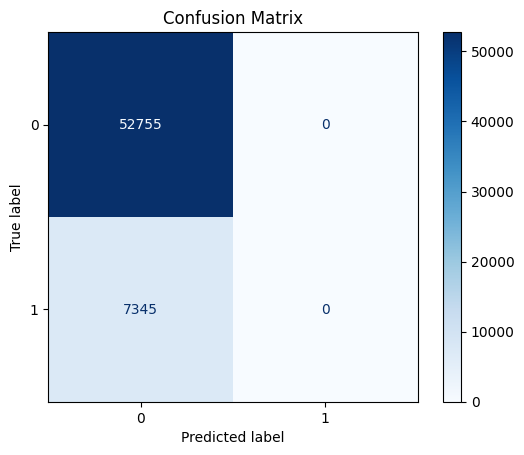


Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      1.00      0.93     52755
    Abnormal       0.00      0.00      0.00      7345

    accuracy                           0.88     60100
   macro avg       0.44      0.50      0.47     60100
weighted avg       0.77      0.88      0.82     60100



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMCls(in_feat=8, hidden=64, layers=2, num_cls=2).to(device)
model.load_state_dict(torch.load('./models/brand1/brand1_fold5_best.pth', map_location=device))

# 3. 테스트 데이터 로드
test_pkl_files = glob('./dataset/battery_brand1/test/*.pkl')

X_list, y_list, lengths = [], [], []

for path in test_pkl_files:
    x, meta = torch.load(path, weights_only=False)
    label = int(meta['label'])  # 예: '00' → 0, '01' → 1

    X_tensor = torch.tensor(x, dtype=torch.float)
    X_list.append(X_tensor)
    y_list.append(label)
    lengths.append(len(X_tensor))

# 패딩 처리
X_padded = pad_sequence(X_list, batch_first=True)
lengths = torch.tensor(lengths)
y_true = torch.tensor(y_list)

# 모델 예측
with torch.no_grad():
    model.eval()
    outputs = model(X_padded.to(device), lengths.to(device))
    preds = torch.argmax(outputs, dim=1).cpu()


# 6. 평가 및 시각화
print("F1 Score:", f1_score(y_true, preds, average='macro'))

cm = confusion_matrix(y_true, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, preds, target_names=['Normal', 'Abnormal']))

F1 Score: 0.26688655464265726


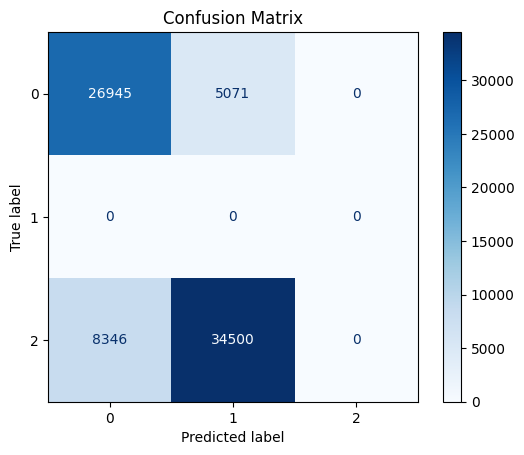


Classification Report:


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMCls(in_feat=8, hidden=128, layers=3, num_cls=2).to(device)
model.load_state_dict(torch.load('./models/brand2/brand2_final_full_model_v2.pth', map_location=device))

# 3. 테스트 데이터 로드
test_pkl_files = glob('./dataset/battery_brand2/test/*.pkl')

X_list, y_list, lengths = [], [], []

for path in test_pkl_files:
    x, meta = torch.load(path, weights_only=False)
    label = int(meta['label'])  # 예: '00' → 0, '01' → 1

    X_tensor = torch.tensor(x, dtype=torch.float)
    X_list.append(X_tensor)
    y_list.append(label)
    lengths.append(len(X_tensor))

# 패딩 처리
X_padded = pad_sequence(X_list, batch_first=True)
lengths = torch.tensor(lengths)
y_true = torch.tensor(y_list)

# 모델 예측
with torch.no_grad():
    model.eval()
    outputs = model(X_padded.to(device), lengths.to(device))
    preds = torch.argmax(outputs, dim=1).cpu()


# 6. 평가 및 시각화
print("F1 Score:", f1_score(y_true, preds, average='macro'))

cm = confusion_matrix(y_true, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, preds, target_names=['Normal', 'Abnormal']))

Total files: 29598 | Train: 23678 | Test: 5920
F1 Score: 0.20770384540138687


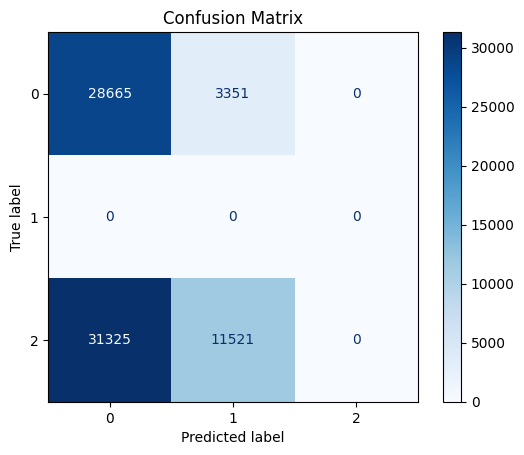


Classification Report:


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMCls(in_feat=8, hidden=64, layers=2, num_cls=2).to(device)
model.load_state_dict(torch.load('./models/brand3/brand3_fold3_best.pth', map_location=device))

# 3. 테스트 데이터 로드
brand_idx = 3
base_dir = './dataset'
data_dir = os.path.join(base_dir, f'battery_brand{brand_idx}', 'data')
all_files = sorted(glob(os.path.join(data_dir, '*.pkl')))

# 2. 셔플 후 split
random.seed(42)
random.shuffle(all_files)

cut = int(len(all_files) * 0.8)
train_files = all_files[:cut]
test_files = all_files[cut:]

print(f"Total files: {len(all_files)} | Train: {len(train_files)} | Test: {len(test_files)}")

X_list, y_list, lengths = [], [], []

for path in test_pkl_files:
    x, meta = torch.load(path, weights_only=False)
    label = int(meta['label'])  # 예: '00' → 0, '01' → 1

    X_tensor = torch.tensor(x, dtype=torch.float)
    X_list.append(X_tensor)
    y_list.append(label)
    lengths.append(len(X_tensor))

# 패딩 처리
X_padded = pad_sequence(X_list, batch_first=True)
lengths = torch.tensor(lengths)
y_true = torch.tensor(y_list)

# 모델 예측
with torch.no_grad():
    model.eval()
    outputs = model(X_padded.to(device), lengths.to(device))
    preds = torch.argmax(outputs, dim=1).cpu()


# 6. 평가 및 시각화
print("F1 Score:", f1_score(y_true, preds, average='macro'))

cm = confusion_matrix(y_true, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, preds, target_names=['Normal', 'Abnormal']))